In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import numpy as np
import geopandas as gpd
import shapely
from typing import Iterable, Tuple, Dict

import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N
from src.models.geograph import GeoGraph
from src.models.geotimeline import TimedGeoGraph, GeoGraphTimeline
from src.models.binary_graph_operations import NodeMap, identify_graphs, graph_polygon_diff, node_polygon_diff

from shapely.geometry import Polygon

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
TEST_DATA_FOLDER = SRC_PATH / "tests" / "testdata"
TEST_DATA_FOLDER.mkdir(parents=True, exist_ok=True)

# 1. Stacking graph at different time-slices

## Load graph trial data over time

In [6]:
t0 = TimedGeoGraph(time=0, data=TEST_DATA_FOLDER / "timestack" / "time_0.gpkg", crs=UTM35N)
t1 = TimedGeoGraph(time=1, data=TEST_DATA_FOLDER / "timestack" / "time_1.gpkg", crs=UTM35N)
t2 = TimedGeoGraph(time=2, data=TEST_DATA_FOLDER / "timestack" / "time_2.gpkg", crs=UTM35N)
t3 = TimedGeoGraph(time=3, data=TEST_DATA_FOLDER / "timestack" / "time_3.gpkg", crs=UTM35N)
t4 = TimedGeoGraph(time=4, data=TEST_DATA_FOLDER / "timestack" / "time_4.gpkg", crs=UTM35N)

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 11/11 [00:00<00:00, 5372.93it/s]
Step 2 of 2: Adding edges: 100%|██████████| 11/11 [00:00<00:00, 69379.46it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 10/10 [00:00<00:00, 5736.19it/s]
Step 2 of 2: Adding edges: 100%|██████████| 10/10 [00:00<00:00, 59833.15it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 4735.76it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 81442.80it/s]


Graph successfully loaded with 11 nodes and 21 edges.
Graph successfully loaded with 10 nodes and 21 edges.
Graph successfully loaded with 6 nodes and 9 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 8/8 [00:00<00:00, 5513.38it/s]
Step 2 of 2: Adding edges: 100%|██████████| 8/8 [00:00<00:00, 77314.36it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 8/8 [00:00<00:00, 5497.12it/s]
Step 2 of 2: Adding edges: 100%|██████████| 8/8 [00:00<00:00, 86928.58it/s]

Graph successfully loaded with 8 nodes and 15 edges.
Graph successfully loaded with 8 nodes and 13 edges.


In [7]:
def calculate_growth_rates(mapping: NodeMap):  # TODO: numba
    
    backward_map = ~mapping
    relative_growth_rates = np.zeros(len(backward_map.mapping))
    absolute_growth_rates = np.zeros(len(backward_map.mapping))
    for i, (future, past) in enumerate(backward_map.mapping.items()):
        past_area = np.sum(backward_map.trg_graph.df.geometry.loc[past].area)
        future_area = np.sum(backward_map.src_graph.df.geometry.loc[future].area)
        
        relative_growth_rates[i] =  (future_area - past_area) / (future_area + past_area)
        absolute_growth_rates[i] =  (future_area - past_area)
        
    return relative_growth_rates, absolute_growth_rates

In [8]:
graphs = GeoGraphTimeline([t0, t1, t2, t3, t4])

In [9]:
graphs.timestack()

In [10]:
graphs.empty_node_map_cache()

In [11]:
maps = graphs.timestack()

In [12]:
relative_growth_rate, absolute_growth_rate = calculate_growth_rates(maps[0])

In [13]:
absolute_growth_rate

array([ 0.,  0.,  1.,  1., -2.,  1.,  2.,  0.,  4.,  0.])

In [12]:
def debug_plot(geograph, annotate=True):
    geograph.df.plot("class_label")
    if annotate:
        for index, point in geograph.df.representative_point().items():
            plt.text(point.x, point.y, index, color="black")

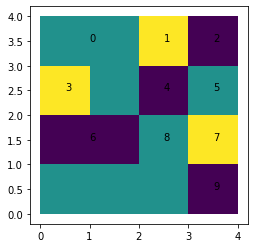

In [13]:
debug_plot(t1)

In [14]:
from src.tests.utils import polygonise, get_array_transform

In [15]:
before = np.array([
    [3, 3, 3, 3],
    [1, 1, 1, 2],
    [3, 3, 2, 1],
    [2, 2, 2, 3],
], dtype=np.uint16)

In [16]:
before = np.array([
    [3, 3, 3, 3],
    [1, 1, 1, 2],
    [3, 3, 2, 1],
    [2, 2, 2, 3],
], dtype=np.uint16)

after = np.array([
    [3, 3, 3, 3],
    [1, 1, 1, 2],
    [3, 3, 2, 2],
    [1, 3, 2, 2],
], dtype=np.uint16)

before = polygonise(before,  transform=get_array_transform(before))
after = polygonise(after,  transform=get_array_transform(after))

In [17]:
bg = GeoGraph(before)
ag = GeoGraph(after)

mapping = identify_graphs(bg, ag, mode="interior")
fwd_diff =graph_polygon_diff(mapping)
bwd_diff =graph_polygon_diff(~mapping)

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 7/7 [00:00<00:00, 3720.71it/s]
Step 2 of 2: Adding edges: 100%|██████████| 7/7 [00:00<00:00, 36608.64it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 5/5 [00:00<00:00, 2930.21it/s]
Step 2 of 2: Adding edges: 100%|██████████| 5/5 [00:00<00:00, 31823.25it/s]

Graph successfully loaded with 7 nodes and 12 edges.
Graph successfully loaded with 5 nodes and 6 edges.


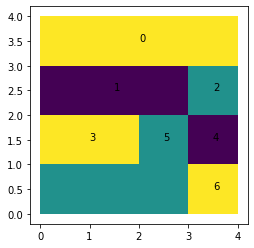

In [18]:
debug_plot(bg)

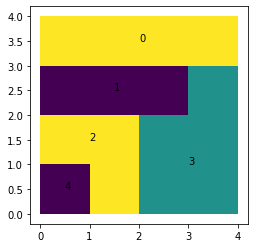

In [19]:
debug_plot(ag)

In [20]:
mapping.mapping

{0: [0], 1: [1], 2: [3], 3: [2], 4: [], 5: [3], 6: []}

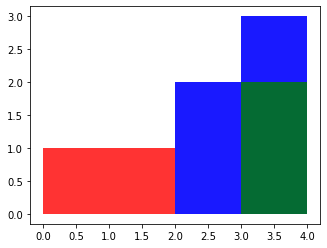

In [21]:
fig, ax = plt.subplots(1)
node_id = 3

ag.df.loc[node_id:node_id].plot(color="blue", ax=ax, alpha=0.9)
bwd_diff[0].loc[node_id:node_id].plot(color="red", ax=ax, alpha=0.8)  # added
bwd_diff[1].loc[node_id:node_id].plot(color="green", alpha=0.8, ax=ax)  # removed
#graph_polygon_diff(maps[0])[2].plot(color="blue", alpha=0.3, ax=ax)
plt.show()

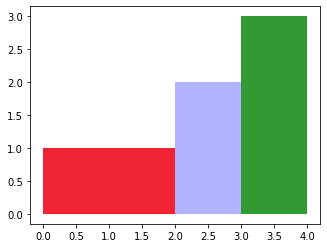

In [22]:
fig, ax = plt.subplots(1)
node_id = 5

bg.df.loc[node_id:node_id].plot(color="blue", ax=ax, alpha=0.3)
fwd_diff[0].loc[node_id:node_id].plot(color="green", ax=ax, alpha=0.8)  # added
fwd_diff[1].loc[node_id:node_id].plot(color="red", alpha=0.8, ax=ax)  # removed
#graph_polygon_diff(maps[0])[2].plot(color="blue", alpha=0.3, ax=ax)
plt.show()

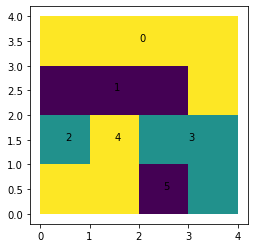

In [23]:
debug_plot(t2)

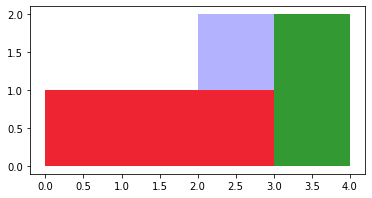

In [24]:
fig, ax = plt.subplots(1)
node_id = 8

t1.df.loc[8:8].plot(color="blue", ax=ax, alpha=0.3)
graph_polygon_diff(maps[1])[0].loc[node_id:node_id].plot(color="green", ax=ax, alpha=0.8)  # added
graph_polygon_diff(maps[1])[1].loc[node_id:node_id].plot(color="red", alpha=0.8, ax=ax)  # removed
#graph_polygon_diff(maps[0])[2].plot(color="blue", alpha=0.3, ax=ax)
plt.show()

In [110]:
from src.data_loading.vector_utils import shapely_to_frame

<AxesSubplot:>

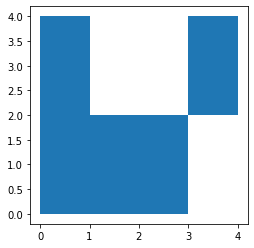

In [27]:
graph_polygon_diff(~maps[0])[1].plot()

In [28]:
(~maps[0]).mapping

{0: [1], 1: [2], 2: [], 3: [], 4: [5], 5: [], 6: [], 7: [7], 8: [], 9: [10]}

In [29]:
relative_growth_rate

array([ 0. ,  0. ,  1. ,  1. , -0.5,  1. ,  1. ,  0. ,  1. ,  0. ])

In [30]:
absolute_growth_rate

array([ 0.,  0.,  1.,  1., -2.,  1.,  2.,  0.,  4.,  0.])

### Test node identification inversion

In [240]:
def identify_graphs_fwd_and_bwd(graph1, graph2): 
    
    fwd_mapping = {index1: [] for index1 in graph1.df.index}
    bwd_mapping = {index2: [] for index2 in graph2.df.index}
    for index in graph1.df.index:
        identified = graph1.identify_node(index, graph2, mode="interior")
        fwd_mapping[index] = identified
        
        for other_index in identified:
            bwd_mapping[other_index].append(index)
            
    return NodeMapping(graph1, graph2, fwd_mapping), NodeMapping(graph2, graph1, bwd_mapping)
        

In [241]:
fwd, bwd = identify_graphs_fwd_and_bwd(t0, t1)

In [242]:
fwd.invert() == bwd

True

In [245]:
~fwd == bwd

True

In [246]:
bwd.invert() == fwd

True

In [247]:
fwd.invert().invert() == fwd

True

In [249]:
~~fwd == fwd

True

# 2. Stacking times - scalabilty experiment via chernobyl data

In [143]:
chernobyl_1992 = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_1992_chernobyl.tif" 
chernobyl_2013 = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_2013_chernobyl.tif" 
chernobyl_2014 = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_2014_chernobyl.tif" 
chernobyl_2015 = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_2015_chernobyl.tif" 

In [144]:
import rioxarray as rxr
from src.data_loading.rasterio_utils import polygonise
from src.constants import GWS_DATA_DIR, ESA_LANDCOVER_DIR, UTM35N

# Parse geotif landcover data
chernobyl_2015 = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_2015_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson")
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]

In [145]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

In [146]:
cez_raster_1992 = clip_and_reproject(rxr.open_rasterio(chernobyl_1992), clip_geometry=cez.geometry)
cez_raster_2013 = clip_and_reproject(rxr.open_rasterio(chernobyl_2013), clip_geometry=cez.geometry)
cez_raster_2014 = clip_and_reproject(rxr.open_rasterio(chernobyl_2014), clip_geometry=cez.geometry)
cez_raster_2015 = clip_and_reproject(rxr.open_rasterio(chernobyl_2015), clip_geometry=cez.geometry)

In [147]:
cez_poly_1992 = polygonise(cez_raster_1992.data, 
                           transform=cez_raster_1992.rio.transform(),
                           crs=UTM35N)
cez_poly_2013 = polygonise(cez_raster_2013.data, 
                           transform=cez_raster_2013.rio.transform(),
                           crs=UTM35N)
cez_poly_2014 = polygonise(cez_raster_2014.data, 
                           transform=cez_raster_2014.rio.transform(),
                           crs=UTM35N)
cez_poly_2015 = polygonise(cez_raster_2015.data, 
                           transform=cez_raster_2015.rio.transform(),
                           crs=UTM35N)

In [148]:
%%time
cez_graph_1992 = GeoGraph(cez_poly_1992[cez_poly_1992.class_label != 0])

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2692/2692 [00:18<00:00, 147.61it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2692/2692 [00:00<00:00, 30302.31it/s]

Graph successfully loaded with 2692 nodes and 7392 edges.
CPU times: user 16.5 s, sys: 1.38 s, total: 17.8 s
Wall time: 18.6 s


In [149]:
%%time
cez_graph_2014 = GeoGraph(cez_poly_2014[cez_poly_2014.class_label != 0])

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2915/2915 [00:12<00:00, 232.56it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2915/2915 [00:00<00:00, 25025.22it/s]

Graph successfully loaded with 2915 nodes and 8189 edges.
CPU times: user 11.9 s, sys: 858 ms, total: 12.8 s
Wall time: 13.1 s


In [150]:
%%time
cez_graph_2015 = GeoGraph(cez_poly_2015[cez_poly_2015.class_label != 0])

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2915/2915 [00:13<00:00, 211.27it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2915/2915 [00:00<00:00, 29361.23it/s]

Graph successfully loaded with 2915 nodes and 8189 edges.
CPU times: user 13.1 s, sys: 780 ms, total: 13.9 s
Wall time: 14.4 s


In [151]:
%%time
cez_graph_2013 = GeoGraph(cez_poly_2013[cez_poly_2013.class_label != 0])

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2923/2923 [00:14<00:00, 205.26it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2923/2923 [00:00<00:00, 28734.03it/s]

Graph successfully loaded with 2923 nodes and 8219 edges.
CPU times: user 13.6 s, sys: 923 ms, total: 14.5 s
Wall time: 14.8 s


In [154]:
%%time
map_13_to_14 = identify_graphs(cez_graph_2013, cez_graph_2014, mode="interior")

CPU times: user 6.24 s, sys: 537 ms, total: 6.78 s
Wall time: 6.93 s


In [155]:
%%time
diff_13_to_14 = graph_polygon_diff(map_13_to_14)

CPU times: user 5.24 s, sys: 612 ms, total: 5.86 s
Wall time: 6.09 s


<AxesSubplot:>

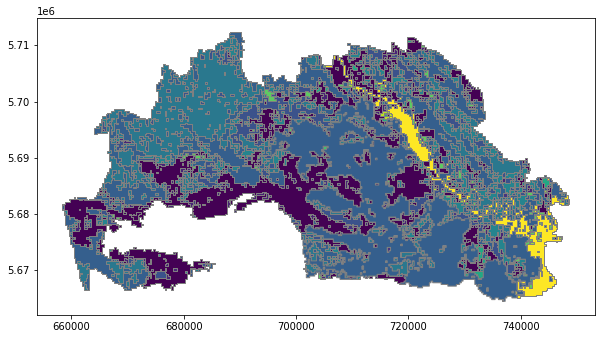

In [166]:
fig, ax = plt.subplots(1, figsize=(10,10))
cez_graph_2013.df.plot("class_label", ax=ax, edgecolor="grey")

<AxesSubplot:>

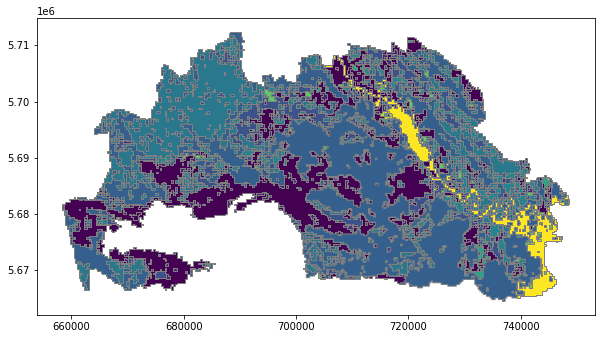

In [167]:
fig, ax = plt.subplots(1, figsize=(10,10))
cez_graph_2014.df.plot("class_label", ax=ax, edgecolor="grey")

In [175]:
cez_graph_2013.df.loc[2920]

geometry       POLYGON ((696113.7255258427 5693240.226702846,...
class_label                                                   70
Name: 2920, dtype: object

In [176]:
map_13_to_14.mapping[2920]

[2912]

In [179]:
a, b = node_polygon_diff(2920, map_13_to_14)

<AxesSubplot:>

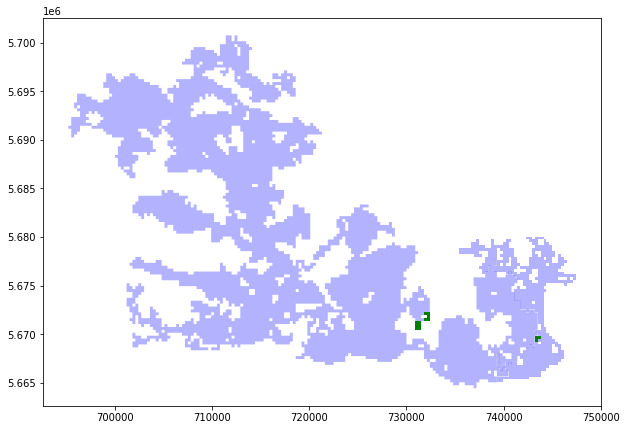

In [201]:
fig, ax = plt.subplots(1, figsize=(10,10))
cez_graph_2013.df.loc[2920:2921].plot(color="blue", ax=ax, alpha=0.3)
shapely_to_frame(a).plot(color="green", ax=ax)
shapely_to_frame(b).plot(color="red", ax=ax)

<AxesSubplot:>

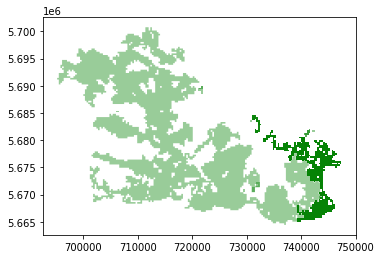

In [190]:
added_parts.plot( color='green', alpha=0.4)

In [186]:
removed_parts.loc[2920].geometry

<AxesSubplot:>

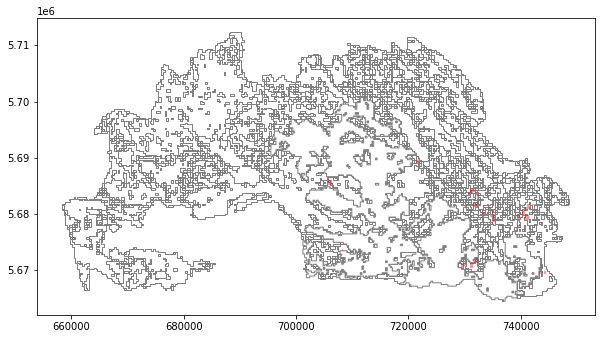

In [188]:
fig, ax = plt.subplots(1, figsize=(10,10))

added_parts = diff_13_to_14[0]
removed_parts = diff_13_to_14[1]

cez_graph_2013.df.plot(ax=ax, color="white", edgecolor="grey")

#added_parts.plot(ax=ax, color='green', alpha=0.4)
removed_parts.plot(ax=ax, color='red', alpha=0.4)

In [50]:
%%timeit
~map_13_to_14 

1.19 ms ± 9.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [54]:
%%time
rel_13_14, abs_13_14 = calculate_growth_rates(map_13_to_14)

CPU times: user 2.09 s, sys: 83.7 ms, total: 2.17 s
Wall time: 2.18 s


In [62]:
cez_graph_2014.df["rel_growth"] = rel_13_14 * 100
cez_graph_2014.df["abs_growth"] = abs_13_14 / 1e4

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

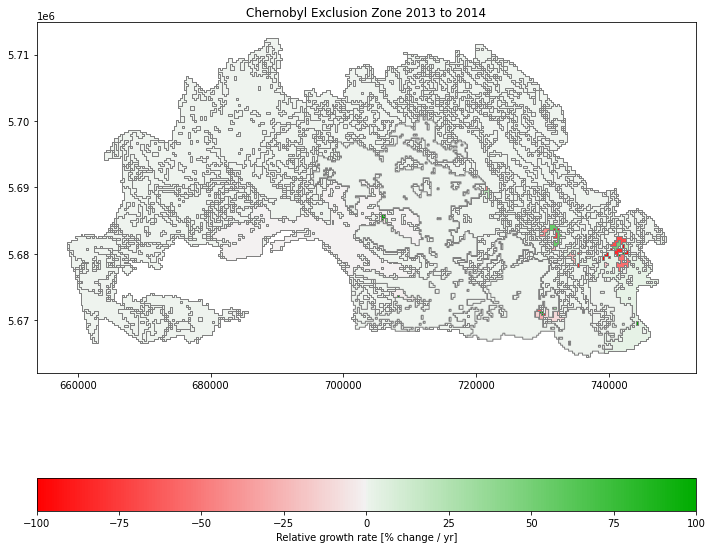

In [74]:
fig, ax = plt.subplots(1, figsize=(10,10))

cmap = sns.diverging_palette(6, 120, s=360, l=55, as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-100, vmax=100)

cez_graph_2014.df.plot("rel_growth", ax=ax, cmap=cmap, norm=norm, edgecolor="grey")

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='horizontal', 
             label='Relative growth rate [% change / yr]')
plt.title("Chernobyl Exclusion Zone 2013 to 2014")
plt.tight_layout()

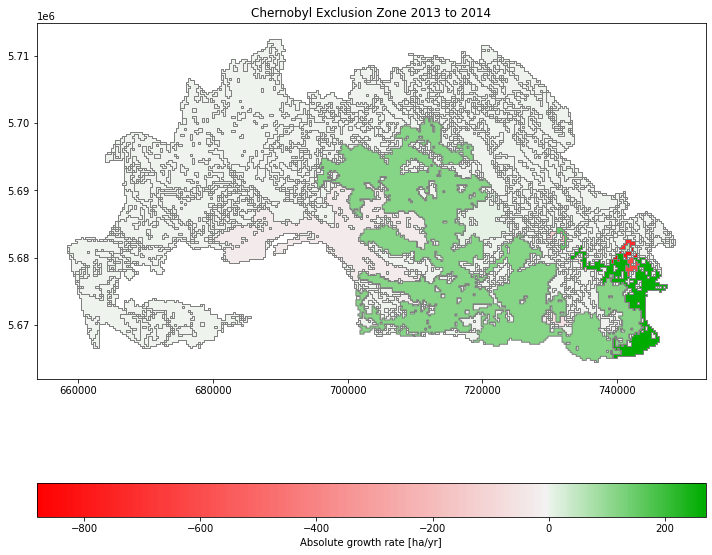

In [73]:
fig, ax = plt.subplots(1, figsize=(10,10))

cmap = sns.diverging_palette(6, 120, s=360, l=55, as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, 
                               vmin=cez_graph_2014.df.abs_growth.min(), 
                               vmax=cez_graph_2014.df.abs_growth.max())

cez_graph_2014.df.plot("abs_growth", ax=ax, cmap=cmap, norm=norm, edgecolor="grey")

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='horizontal', 
             label='Absolute growth rate [ha/yr]')
plt.title("Chernobyl Exclusion Zone 2013 to 2014")
plt.tight_layout()

In [321]:
node_deaths = [key for key, val in map_13_to_14.mapping.items() if len(val)==0]
node_births = [key for key, val in (~map_13_to_14).mapping.items() if len(val)==0]
node_splits = [key for key, val in map_13_to_14.mapping.items() if len(val) > 1]
node_merges = [key for key, val in (~map_13_to_14).mapping.items() if len(val) > 1]

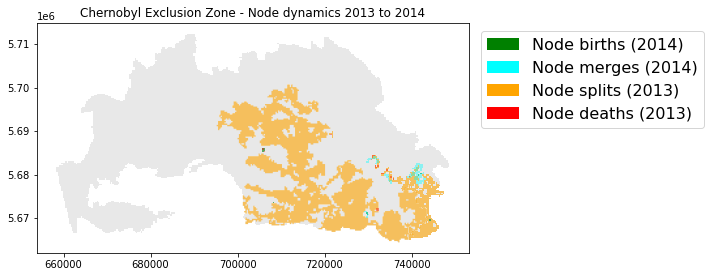

In [331]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1, figsize=(10,10))

cez_graph_2014.df.plot(color="lightgrey", ax=ax, alpha=0.5)
cez_graph_2014.df.loc[node_births].plot(color="green", ax=ax, alpha=0.6, label="Node births (2014)")
cez_graph_2014.df.loc[node_merges].plot(color="orange", ax=ax, alpha=0.6, label="Node merges (2014)")
cez_graph_2013.df.loc[node_splits].plot(color="cyan", ax=ax, alpha=0.4, label="Node splits (2013)")
cez_graph_2013.df.loc[node_deaths].plot(color="red", ax=ax, alpha=0.4, label="Node deaths (2013)")

#ax.set_yticks([])
#ax.set_xticks([])

label_names = ["Node births (2014)", "Node merges (2014)", "Node splits (2013)", "Node deaths (2013)"]
label_colors = ["green", "cyan", "orange", "red"]
legend_elements = []
legend_elements = [(Patch(label=name, facecolor=color)) for name, color in zip(label_names, label_colors)]
ax.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.01, 1),  # places legend to the right of the image
    loc="upper left",  # anchor for the bbox_to_anchor statement
    prop={"size": 16},  # fontsize in legend
)
plt.title("Chernobyl Exclusion Zone - Node dynamics 2013 to 2014"); 
plt.tight_layout()

In [252]:
%%time
map_92_to_14 = identify_graphs(cez_graph_, cez_graph_2014)

CPU times: user 3.44 s, sys: 63.8 ms, total: 3.5 s
Wall time: 4 s


In [276]:
cez_graph_2014.df["growth_rate"] = calculate_growth_rates(map_92_to_14)

<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by zero encountered in double_scalars
  growth_rates[i] =  (future_area - past_area) / past_area
<ipython-input-138-c6cbf56b685a>:9: RuntimeWarning: divide by ze

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


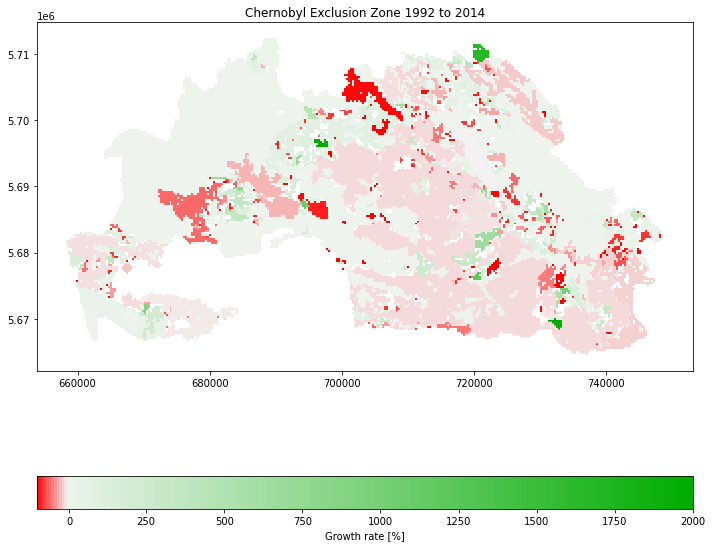

In [277]:
fig, ax = plt.subplots(1, figsize=(10,10))

valid_growth_df = cez_graph_2014.df[cez_graph_2014.df["growth_rate"] != np.inf]
valid_growth_df["growth_rate"] = valid_growth_df["growth_rate"] * 100

cmap = sns.diverging_palette(6, 120, s=360, l=55, as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=valid_growth_df.growth_rate.min(), vmax=valid_growth_df.growth_rate.max())

valid_growth_df.plot("growth_rate", ax=ax, cmap=cmap, norm=norm)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='horizontal', 
             label='Growth rate [%]')
plt.title("Chernobyl Exclusion Zone 1992 to 2014")
plt.tight_layout()

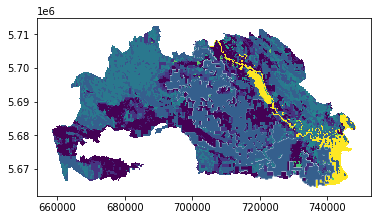

In [281]:
debug_plot(cez_graph_1992, annotate=False)

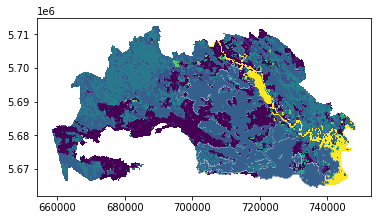

In [282]:
debug_plot(cez_graph_2014, annotate=False)

In [332]:
node_deaths = [key for key, val in map_92_to_14.mapping.items() if len(val)==0]
node_births = [key for key, val in (~map_92_to_14).mapping.items() if len(val)==0]
node_splits = [key for key, val in map_92_to_14.mapping.items() if len(val) > 1]
node_merges = [key for key, val in (~map_92_to_14).mapping.items() if len(val) > 1]

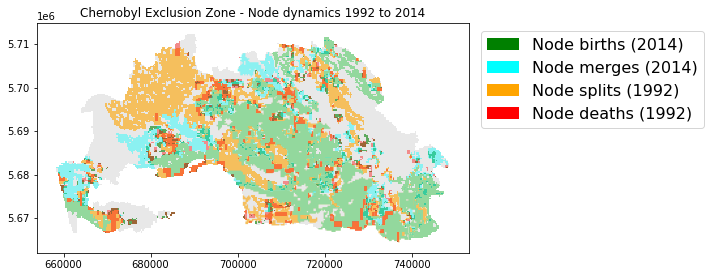

In [333]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1, figsize=(10,10))

cez_graph_2014.df.plot(color="lightgrey", ax=ax, alpha=0.5)
cez_graph_2014.df.loc[node_births].plot(color="green", ax=ax, alpha=0.6, label="Node births (2014)")
cez_graph_2014.df.loc[node_merges].plot(color="orange", ax=ax, alpha=0.6, label="Node merges (2014)")
cez_graph_1992.df.loc[node_splits].plot(color="cyan", ax=ax, alpha=0.4, label="Node splits (2013)")
cez_graph_1992.df.loc[node_deaths].plot(color="red", ax=ax, alpha=0.4, label="Node deaths (2013)")

#ax.set_yticks([])
#ax.set_xticks([])

label_names = ["Node births (2014)", "Node merges (2014)", "Node splits (1992)", "Node deaths (1992)"]
label_colors = ["green", "cyan", "orange", "red"]
legend_elements = []
legend_elements = [(Patch(label=name, facecolor=color)) for name, color in zip(label_names, label_colors)]
ax.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.01, 1),  # places legend to the right of the image
    loc="upper left",  # anchor for the bbox_to_anchor statement
    prop={"size": 16},  # fontsize in legend
)
plt.title("Chernobyl Exclusion Zone - Node dynamics 1992 to 2014"); 
plt.tight_layout()

In [339]:
cez_graph_2014.df["Area"] = cez_graph_2014.df.area / 1e4

<AxesSubplot:xlabel='Area', ylabel='growth_rate'>

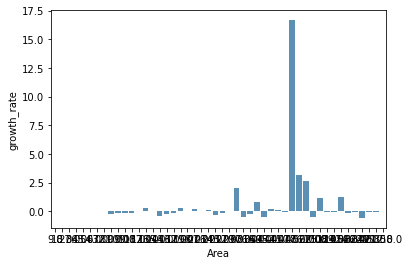

In [377]:
series = cez_graph_2014.df[cez_graph_2014.df.class_label == 10].groupby("Area").growth_rate.median()
sns.barplot(x=series.index, y=series, color="C0", alpha=0.8)

# 3. Merging graphs at same timeslice

In [4]:
full = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "full.gpkg")
upper_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_right.gpkg")
upper_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_left.gpkg")
lower_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_right.gpkg")
lower_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_left.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 9/9 [00:00<00:00, 1237.10it/s]
Step 2 of 2: Adding edges: 100%|██████████| 9/9 [00:00<00:00, 20111.21it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 5/5 [00:00<00:00, 1275.56it/s]
Step 2 of 2: Adding edges: 100%|██████████| 5/5 [00:00<00:00, 17848.10it/s]


Graph successfully loaded with 9 nodes and 19 edges.
Graph successfully loaded with 5 nodes and 6 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 7/7 [00:00<00:00, 1253.90it/s]
Step 2 of 2: Adding edges: 100%|██████████| 7/7 [00:00<00:00, 18012.35it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 1390.15it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 19122.97it/s]


Graph successfully loaded with 7 nodes and 13 edges.
Graph successfully loaded with 6 nodes and 10 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 1210.30it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 17759.93it/s]

Graph successfully loaded with 6 nodes and 12 edges.


<AxesSubplot:>

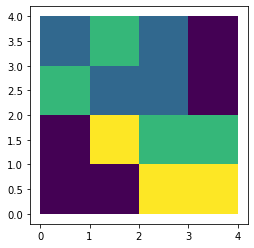

In [46]:
full.df.plot("class_label")

<AxesSubplot:>

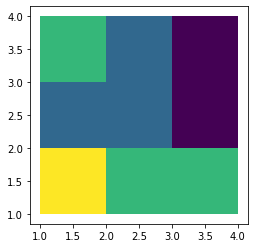

In [47]:
upper_right.df.plot("class_label")

In [48]:
full.identify_node(3, upper_right, mode="corner")

array([0])

In [49]:
type(upper_right)

src.models.geograph.GeoGraph

In [50]:
isinstance(upper_right, GeoGraph)

True

<AxesSubplot:>

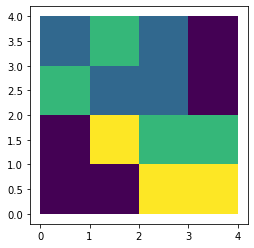

In [51]:
full.df.plot("class_label")

<AxesSubplot:>

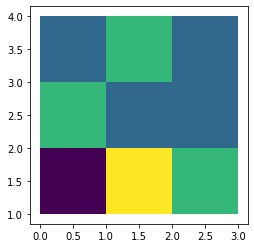

In [52]:
upper_left.df.plot("class_label")

In [53]:
full._merge_graph(upper_left)

[4]
[5]
[2]
[0]
[1]
[]
[6]
[3]
[]


NotImplementedError: 

In [54]:
upper_left.bounds

array([0., 1., 3., 4.])

In [55]:
upper_right.bounds

array([1., 1., 4., 4.])

In [56]:
full.bounds

array([0., 0., 4., 4.])

In [57]:
sorted(upper_left.rtree.intersection(lower_right.bounds))

[0, 1, 2, 3, 4, 5, 6]

In [32]:
hole = upper_left.df.drop([3])

In [77]:
hole.index.values[4]

5

In [39]:
hole

,class_label,geometry
node_index,,
0,2,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1...."
1,3,"POLYGON ((1.00000 4.00000, 2.00000 4.00000, 2...."
2,3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1...."
4,1,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1...."
5,4,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
6,3,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3...."


In [38]:
hole.sindex.intersection(lower_right.bounds)

array([3, 2, 0, 4, 5, 1])

In [ ]:
%%timeit
upper_left.identify_node(3, upper_right, mode="corner")

In [57]:
full

In [59]:
full.graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8))

In [61]:
full.graph.nodes

NodeView((0, 1, 2, 4, 5, 6, 7, 8))

In [66]:
%%timeit
full.df.drop(index=3)

1.49 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
%%timeit
full.df.drop([3,5,6])

1.73 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
